In [ ]:
import os
import pickle
import numpy as np
from tqdm.notebook import tqdm # ui for data processing
import tarfile
from google.colab import drive
import glob
import shutil
import re
import string
import zipfile
import requests
import random
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add
from tensorflow.keras.layers import TextVectorization

In [ ]:
# mount Google Drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
GDRIVE_WORKING_PATH = "/content/gdrive/MyDrive/image_cap"
CAPTION_DIR = "/content/gdrive/MyDrive/image_cap/iaprtc12/captions"

# Text Data


## Load Captions Data + Clean

In [ ]:
def preprocess(c):
  caption = c
  caption = caption.lower() # to lowercase
  caption = caption.translate(str.maketrans('', '', string.punctuation)) # removing punctuation
  caption = caption.replace("\s+", " ") # replace multiple space with one space only
  caption = f"[start] {' '.join([word for word in caption.split() if len(word) > 1])} [end]" # add tags, remove one char words
  return caption

In [ ]:
# create mapping id caption
def clean_captions_and_save(list_ids, name):
  caption_mapping = {}

  for caption_name in tqdm(list_ids):
    # load the image from file
    caption_path = f"{CAPTION_DIR}/{caption_name}.eng"
    # <DESCRIPTION> </DESCRIPTION>
    with open(caption_path, "r", encoding='latin-1') as f:
      caption_str = f.read().replace("\n", "")
      result = re.search('<DESCRIPTION>(.*)</DESCRIPTION>', caption_str)
      caption = result.group(1)
      caption_mapping[f"{caption_name}"] = preprocess(caption)

  # save clean captions
  pickle.dump(caption_mapping, open(os.path.join(GDRIVE_WORKING_PATH, f"{name}.pkl"), "wb"))

In [ ]:
with open(f"{GDRIVE_WORKING_PATH}/list_id_train.pkl", "rb") as f:
  train_ids = pickle.load(f)
with open(f"{GDRIVE_WORKING_PATH}/list_id_test.pkl", "rb") as f:
  test_ids = pickle.load(f)
with open(f"{GDRIVE_WORKING_PATH}/list_id_val.pkl", "rb") as f:
  val_ids = pickle.load(f)

In [ ]:
if False:
  clean_captions_and_save(train_ids, "dict_clean_captions_train")
  clean_captions_and_save(test_ids, "dict_clean_captions_test")
  clean_captions_and_save(val_ids, "dict_clean_captions_val")

In [ ]:
with open(os.path.join(GDRIVE_WORKING_PATH, "dict_clean_captions_train.pkl"), "rb") as f:
  clean_captions_train = pickle.load(f)
with open(os.path.join(GDRIVE_WORKING_PATH, "dict_clean_captions_test.pkl"), "rb") as f:
  clean_captions_test = pickle.load(f)
with open(os.path.join(GDRIVE_WORKING_PATH, "dict_clean_captions_val.pkl"), "rb") as f:
  clean_captions_val = pickle.load(f)

## Viz

Text(0.5, 1.0, 'Number of Words per Caption')

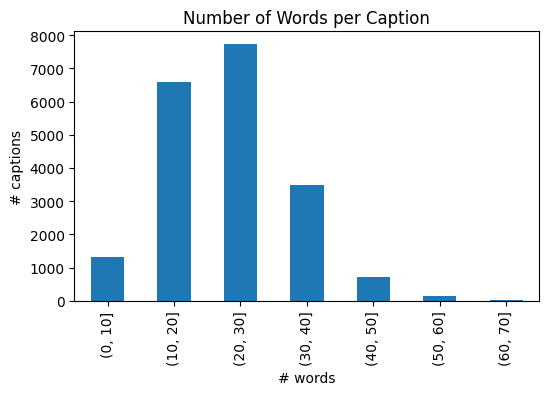

In [ ]:
full_list = list(clean_captions_train.values()) + list(clean_captions_test.values()) + list(clean_captions_val.values())
len_dist = [len(v.split(" ")) for v in full_list]

fig, ax = plt.subplots(figsize=(6, 3.5))
(
    pd.cut(len_dist, bins=np.arange(0, 80, 10))
        .value_counts()
        .sort_index()
        .plot.bar(ax=ax)
)
plt.ylabel('# captions')
plt.xlabel('# words')
plt.title("Number of Words per Caption")

In [ ]:
full_text = ""
for t in full_list:
  full_text += " " + t[8:-5]

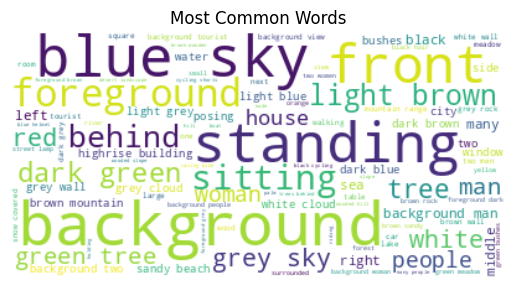

In [ ]:
# Start with one review:

# Create and generate a word cloud image:
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(full_text)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Most Common Words")
plt.show()

In [ ]:
# example caption
list(clean_captions_train.values())[0]

'[start] people are getting off red speedboat onto wooden jetty in harbour [end]'

In [ ]:
list(clean_captions_train.keys())[0]

'32811'

## Tokenizer Creation

In [ ]:
list(clean_captions_train.values())[:5]

['[start] people are getting off red speedboat onto wooden jetty in harbour [end]',
 '[start] the roots of trees in dense dark mangrove forest [end]',
 '[start] two men and two women are standing on light brown walk next to grey rocks and green cactuses [end]',
 '[start] view of white two and threestorey building with many columns tables and potted plants on the ground level and turquoise rails on the balcony on the second floor [end]',
 '[start] front view of yellow church with two towers and brown central nave with an arched entrance with many columns statues and ornaments around it there are people on the grey square in front of it [end]']

Check the length of the longest caption

In [ ]:
np.max([len(a.split(" ")) for a in list(clean_captions_train.values())])

73

In [ ]:
np.median([len(a.split(" ")) for a in list(clean_captions_train.values())])

23.0

In [ ]:
# tokenize text
total_words = 5000
words_per_sentence = 73
# Instantiate a vectorizer
vectorizer = TextVectorization(
    max_tokens=total_words,
    output_sequence_length=words_per_sentence
)

## Vocabulary

In [ ]:
list_captions_train = list(clean_captions_train.values())
list_captions_test = list(clean_captions_test.values())
list_captions_val = list(clean_captions_val.values())

In [ ]:
text_ds = tf.data.Dataset.from_tensor_slices(list_captions_train).batch(128)
vectorizer.adapt(text_ds)

In [ ]:
vocab_size = len(vectorizer.get_vocabulary())

In [ ]:
vectorized_caption_train = vectorizer(list_captions_train).numpy()
vectorized_caption_test = vectorizer(list_captions_test).numpy()
vectorized_caption_val = vectorizer(list_captions_val).numpy()

In [ ]:
if False:
  pickle.dump(vectorized_caption_train, open(f"{GDRIVE_WORKING_PATH}/vectorized_captions_train.pkl", "wb"))
  pickle.dump(vectorized_caption_test, open(f"{GDRIVE_WORKING_PATH}/vectorized_captions_test.pkl", "wb"))
  pickle.dump(vectorized_caption_val, open(f"{GDRIVE_WORKING_PATH}/vectorized_captions_val.pkl", "wb"))

In [ ]:
# save vectorizer
if False:
  pickle.dump({"config": vectorizer.get_config(), "weights": vectorizer.get_weights()}, open(f"{GDRIVE_WORKING_PATH}/vectorizer.pkl", "wb"))

## Embedding

An embedding is a data structure used to map a set of disjoint elements into a continuous N-dimensional space.<br/>
In our case, we map all words from our vocabulary into a 100-dimensional space:<br/>
Each word will be replaced by a 100-dimensional vector.<br/>

### Using GloVe

In [ ]:
# Copy and extract embedding file
shutil.copyfile(f"{GDRIVE_WORKING_PATH}/glove.6B.100d.zip", "glove.6B.100d.zip")
zipf = zipfile.ZipFile("glove.6B.100d.zip")
zipf.extractall()
zipf.close()

In [ ]:
# step 1 --> import GloVe

embeddings_index = {}
with open("glove.6B.100d.txt") as f:
  # For each text line
  for line in f:
    # Separate the word-string from the 100-dimensional-vector-string
    word, coeffs = line.split(maxsplit=1)
    # Convert 100-dimensional vector string into a proper floating point vector
    coeffs = np.fromstring(coeffs, "f", sep=" ")
    # Create a new dictionary entry
    embeddings_index[word] = coeffs

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [ ]:
# step 2 --> create embedding matrix
embedding_dim = 100
embedding_matrix = np.zeros((vocab_size, embedding_dim))

# For each word in our vocabulary
for i, word in enumerate(vectorizer.get_vocabulary()):
  # Search corresponding embedding in GloVe,
  # and add it in the correct row of the embedding matrix
  embedding_vector = embeddings_index.get(word)
  if embedding_vector is not None:
      embedding_matrix[i] = embedding_vector
  # else: words not found in embedding index will be all-zeros.

pickle.dump(embedding_matrix, open(f"{GDRIVE_WORKING_PATH}/embedding_matrix.pkl", "wb"))

In [ ]:
# Transfer the embedding matrix to a Keras Embedding layer
embedding_layer = Embedding(
  vocab_size,
  embedding_dim,
  embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
  trainable=False,
)
pickle.dump(embedding_layer, open(f"{GDRIVE_WORKING_PATH}/embedding_layer.pkl", "wb"))

In [ ]:
print(embedding_matrix.shape) # (5002, 100)
len(vectorizer.get_vocabulary()) # 4159

(4159, 100)


4159

In [ ]:
vectorizer.get_vocabulary()[:20]

['',
 '[UNK]',
 'in',
 'the',
 'and',
 'start',
 'end',
 'with',
 'on',
 'background',
 'of',
 'brown',
 'grey',
 'blue',
 'are',
 'green',
 'is',
 'white',
 'it',
 'sky']

# Data Augmentation

## Synonym Replacement, Random Deletion, Translation

In [ ]:
! pip install textaugment

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.1/55.1 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 23.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 13.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.6/53.6 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.0/65.0 kB 6.8 MB/s eta 0:00:00
  Created wheel for googletrans: filename=googletrans-3.0.0-py3-none-any.whl size=15721 sha256=8f6eaac68cda4a342b83fbd66517c6ef5ab0fff3a6a9720e5e6814444ae96b91
  Stored in directory: /root/.cache/pip/wheels/b3/81/ea/8b030407f8ebfc2f857814e086bb22ca2d4fea1a7be63652ab
Successfully built googletrans
  

In [ ]:
from textaugment import EDA
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
from textaugment import Wordnet
from textaugment import Translate

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
def augment_caption(caption):
  t = EDA(random_state=1)

  print(f"Original --> {caption}")

  # Synonym Replacement
  syn_rep = t.synonym_replacement(caption, n=2)
  print(f"Syn Rep --> {syn_rep}")

  # Random Deletion
  rnd_del = t.random_deletion(caption, p=0.3)
  print(f"Rnd Del --> {rnd_del}")

  # Translated
  t = Translate(src="en", to="fr")
  tr = t.augment(caption)
  print(f"Translated --> {tr}")

**Example with some of IAPR captions**

In [ ]:
for caption in list(clean_captions_train.values())[0:5]:
  cap_splitted = caption.split(" ")
  cap = " ".join(cap_splitted[1:len(cap_splitted)-1])
  augment_caption(cap)
  print("-------------------------------------------------------------------------------------------")

Original --> people are getting off red speedboat onto wooden jetty in harbour
Syn Rep --> people are getting off bolshie speedboat onto wooden jetty in haven
Rnd Del --> people getting off red speedboat onto wooden in harbour
Translated --> people leave the red gearbox on the wooden pier in the port
-------------------------------------------------------------------------------------------
Original --> the roots of trees in dense dark mangrove forest
Syn Rep --> the roots of corner in dense blue mangrove forest
Rnd Del --> the roots trees in dense dark mangrove forest
Translated --> the roots of trees in dense dark mangroves
-------------------------------------------------------------------------------------------
Original --> two men and two women are standing on light brown walk next to grey rocks and green cactuses
Syn Rep --> two men and two women are standing on light robert brown walking next to grey rocks and green cactuses
Rnd Del --> two men and two women standing on brown n

## Sentence Reverse


In [ ]:
# create mapping id caption
def get_raw_captions_and_save(list_ids, name):
  caption_mapping = {}

  for caption_name in tqdm(list_ids):
    # load the caption from file
    caption_path = f"{CAPTION_DIR}/{caption_name}.eng"
    # <DESCRIPTION> </DESCRIPTION>
    with open(caption_path, "r", encoding='latin-1') as f:
      caption_str = f.read().replace("\n", "")
      result = re.search('<DESCRIPTION>(.*)</DESCRIPTION>', caption_str)
      caption = result.group(1)
      caption_mapping[f"{caption_name}"] = caption

  # save clean captions
  pickle.dump(caption_mapping, open(os.path.join(GDRIVE_WORKING_PATH, f"{name}.pkl"), "wb"))

In [ ]:
if False:
  get_raw_captions_and_save(train_ids, "mapping_id_caption_raw_train")

In [ ]:
def reverse_cap(caption):
  splitted = caption.split(";")
  splitted.reverse()
  joined = "; ".join(splitted)
  return joined

**Example with some IAPR captions**

In [ ]:
with open(f"{GDRIVE_WORKING_PATH}/mapping_id_caption_raw_train.pkl", "rb") as f:
  mapping_captions_train_raw = pickle.load(f)

In [ ]:
for el in list(mapping_captions_train_raw.values())[50:55]:
  ex_sc = reverse_cap(el)
  print(preprocess(ex_sc))

[start] more swimmers are standing behind them swimmers are standing on the starting platforms in an natatorium with pool with lane ropes [end]
[start] grey round highrise building with green windows with green trees and restaurants in the foreground and few cranes and blue sky in the background [end]
[start] blue sky in the background three brown rocks in the sea [end]
[start] room with orange walls black iron bed with brown and white blanket wooden chair at wooden table and dark brown door to toilet [end]
[start] walls with white tiles on the right and on the left many shoes on light brown stairs [end]


## Augmentation

In [ ]:
def augment(mapping, name):
  caption_mapping = {}

  for k, v in tqdm(mapping.items()):

    # init list of captions for each image
    caption_mapping[f"{k}"] = []

    # ---------------------------------------------------------------

    # 1. Sentence Shuffle
    sc = reverse_cap(v)
    caption_mapping[f"{k}"].append(sc)

    # ---------------------------------------------------------------

    t = EDA(random_state=1)
    # 2. Synonym Replacement
    syn_rep = t.synonym_replacement(v, n=2)
    caption_mapping[f"{k}"].append(syn_rep)

    # ---------------------------------------------------------------

    # 3. Random Deletion with p=0.3
    rnd_del = t.random_deletion(v, p=0.3)
    caption_mapping[f"{k}"].append(rnd_del)

    # ---------------------------------------------------------------

    # 4. Translated
    tt = Translate(src="en", to="fr")
    tr = tt.augment(v)
    caption_mapping[f"{k}"].append(tr)

  # save clean shuffled captions
  pickle.dump(caption_mapping, open(os.path.join(GDRIVE_WORKING_PATH, f"{name}.pkl"), "wb"))

In [ ]:
if False:
  augment(mapping_captions_train_raw, "mapping_id_caption_aug")

In [ ]:
with open(f"{GDRIVE_WORKING_PATH}/mapping_id_caption_aug.pkl", "rb") as f:
  mapping_aug = pickle.load(f)

In [ ]:
def preprocess_list(l):
  new_l = []
  for caption in l:
    caption = caption.lower() # to lowercase
    caption = caption.replace("-", " ")
    caption = caption.translate(str.maketrans('', '', string.punctuation)) # removing punctuation
    caption = caption.replace("\s+", " ") # replace multiple space with one space only
    caption = f"[start] {' '.join([word for word in caption.split() if len(word) > 1])} [end]" # add tags, remove one char words
    new_l.append(caption)
  return new_l

In [ ]:
mapping_aug_clean = {k: preprocess_list(v) for k, v in mapping_aug.items()}

In [ ]:
list(mapping_aug_clean.values())[0:2]

[['[start] people are getting off red speedboat onto wooden jetty in harbour [end]',
  '[start] people are capture off red speedboat onto wooden breakwater in harbour [end]',
  '[start] people getting off red speedboat onto wooden jetty [end]',
  '[start] people come out of red speed boat on wooden pier in port [end]'],
 ['[start] the roots of trees in dense dark mangrove forest [end]',
  '[start] the roots of sir herbert beerbohm tree in dense colored mangrove forest [end]',
  '[start] the roots trees in dense dark mangrove [end]',
  '[start] the roots of the trees in dense dark mangrove forest [end]']]

In [ ]:
_ = {mapping_aug_clean[k].append(clean_captions_train[k]) for k, v in mapping_aug_clean.items()}

In [ ]:
list(mapping_aug_clean.values())[0:2]

[['[start] people are getting off red speedboat onto wooden jetty in harbour [end]',
  '[start] people are capture off red speedboat onto wooden breakwater in harbour [end]',
  '[start] people getting off red speedboat onto wooden jetty [end]',
  '[start] people come out of red speed boat on wooden pier in port [end]',
  '[start] people are getting off red speedboat onto wooden jetty in harbour [end]'],
 ['[start] the roots of trees in dense dark mangrove forest [end]',
  '[start] the roots of sir herbert beerbohm tree in dense colored mangrove forest [end]',
  '[start] the roots trees in dense dark mangrove [end]',
  '[start] the roots of the trees in dense dark mangrove forest [end]',
  '[start] the roots of trees in dense dark mangrove forest [end]']]

In [ ]:
pickle.dump(mapping_aug_clean, open(os.path.join(GDRIVE_WORKING_PATH, "augmented_caption_train.pkl"), "wb"))

## Vectorizer and Vocabulary


In [ ]:
augmented_list = [sentence for v_list in list(mapping_aug_clean.values()) for sentence in v_list]

In [ ]:
np.max([len(a.split(" ")) for a in augmented_list])

76

In [ ]:
# tokenize text
total_words = 10000
words_per_sentence = 76
# Instantiate a vectorizer
vectorizer = TextVectorization(
    max_tokens=total_words,
    output_sequence_length=words_per_sentence
)

In [ ]:
text_ds = tf.data.Dataset.from_tensor_slices(augmented_list).batch(128)
vectorizer.adapt(text_ds)

In [ ]:
vocab_size = len(vectorizer.get_vocabulary())
print(vocab_size)

7557


In [ ]:
vectorizer.get_vocabulary()[:10]

['', '[UNK]', 'in', 'the', 'and', 'end', 'start', 'with', 'on', 'background']

In [ ]:
if False:
  aug_list = [list(map(vectorizer, v_list)) for v_list in tqdm(list(mapping_aug_clean.values()))]
  pickle.dump(aug_list, open(f"{GDRIVE_WORKING_PATH}/vectorized_aug_captions_train.pkl", "wb"))
  aug_list_val = [[vectorizer(el)] for el in tqdm(list_captions_val)]
  pickle.dump(aug_list_val, open(f"{GDRIVE_WORKING_PATH}/vectorized_aug_captions_val.pkl", "wb"))

  0%|          | 0/1999 [00:00<?, ?it/s]

In [ ]:
# save vectorizer
if False:
  pickle.dump({"config": vectorizer.get_config(), "weights": vectorizer.get_weights()}, open(f"{GDRIVE_WORKING_PATH}/vectorizer_augmented.pkl", "wb"))

**New Embedding Matrix and Embedding Layer**

In [ ]:
# create embedding matrix
embedding_dim = 100
embedding_matrix = np.zeros((vocab_size, embedding_dim))

# For each word in our vocabulary
for i, word in enumerate(vectorizer.get_vocabulary()):
    # Search corresponding embedding in GloVe,
    # and add it in the correct row of the embedding matrix
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
    # else: words not found in embedding index will be all-zeros.

pickle.dump(embedding_matrix, open(f"{GDRIVE_WORKING_PATH}/embedding_matrix_augmented.pkl", "wb"))

In [ ]:
# Transfer the embedding matrix to a Keras Embedding layer
embedding_layer = Embedding(
    vocab_size,
    embedding_dim,
    embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
    trainable=False,
)
pickle.dump(embedding_layer, open(f"{GDRIVE_WORKING_PATH}/embedding_layer_augmented.pkl", "wb"))

In [ ]:
embedding_matrix.shape

(7557, 100)